In [1]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import gc,math
import missingno

from pandas.tseries.holiday import USFederalHolidayCalendar as calender
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
# Great function to have a general idea about data
# https://www.kaggle.com/bwilsonkg/column-statistics
def show_stats(data_frame):
    stats_column_names = ('column', 'dtype', 'nan_cts', 'nan_perc', 'val_cts',
                          'min', 'max', 'mean', 'median', 'stdev', 'skew', 'kurtosis')
    stats_array = []
    length_df = len(data_frame)
    for column_name in sorted(data_frame.columns):
        col = data_frame[column_name]
        if is_numeric_column(col):
            nan_perc = 100 / length_df * col.isna().sum()
            stats_array.append(
                [column_name, col.dtype, col.isna().sum(), nan_perc, len(col.value_counts()),
                 col.min(), col.max(), col.mean(), col.median(), col.std(), col.skew(),
                 col.kurtosis()])
        else:
            nan_perc = 100 / length_df * col.isna().sum()
            stats_array.append(
                [column_name, col.dtype, col.isna().sum(), nan_perc, len(col.value_counts()),
                 0, 0, 0, 0, 0, 0, 0])
    stats_df = pd.DataFrame(data=stats_array, columns=stats_column_names)
    with pd.option_context('display.float_format', lambda x: '%.1f' % x):
        display(stats_df)

def of_type(stats_data_frame, column_dtype):
    return stats_data_frame[stats_data_frame['dtype'] == column_dtype]

def sort(data_frame, column_name, ascending=False):
    return data_frame.sort_values(column_name, ascending=ascending)       
        
def is_numeric_column(df_column):
    numeric_types = (np.int16, np.float16, np.int32, np.float32,
                     np.int64, np.float64)
    return df_column.dtype in numeric_types

# reducing memory for now, we check later if this affects our models
def reduce_memory(df_):
    for col in df_.columns:
        if df_[col].dtype =='float64': df_[col] = df_[col].astype('float32')
        if df_[col].dtype =='int64': df_[col] = df_[col].astype('int32')
    return df_

In [3]:
path = "C:/Data"
building_df = pd.read_csv(path + "/building_metadata.csv")
weather_train_df = pd.read_csv(path + "/weather_train.csv")
weather_test_df = pd.read_csv(path + "/weather_test.csv")
train_df = pd.read_csv(path + "/train.csv")
test_df = pd.read_csv(path + "/test.csv")
#columns
columns = ["site_id", "building_id", "primary_use", "year_built", "meter"]
#reduce memory
train_df = reduce_memory(train_df)
test_df = reduce_memory(test_df)
#merge into one file to visualize
merge_train_df = pd.merge(pd.merge(train_df, building_df, how="left"), weather_train_df, how="left")
merge_test_df = pd.merge(pd.merge(test_df, building_df, how="left"), weather_test_df, how="left")
#change the form of timestamp
weather_df = pd.concat([weather_train_df, weather_test_df])
weather_df.timestamp = pd.to_datetime(weather_df.timestamp)
merge_train_df.timestamp = pd.to_datetime(merge_train_df.timestamp)
merge_test_df.timestamp  = pd.to_datetime(merge_test_df.timestamp)

del weather_test_df
gc.collect();


# Exploratory Data Analysis(EDA)

In [4]:
show_stats(merge_train_df)

column           dtype   nan_cts  nan_perc  val_cts    min  \
0      air_temperature         float64     96658       0.5      619  -28.9   
1          building_id           int32         0       0.0     1449    0.0   
2       cloud_coverage         float64   8825365      43.7       10    0.0   
3      dew_temperature         float64    100140       0.5      522  -35.0   
4          floor_count         float64  16709167      82.7       18    1.0   
5                meter           int32         0       0.0        4    0.0   
6        meter_reading         float32         0       0.0  1688175    0.0   
7    precip_depth_1_hr         float64   3749023      18.5      128   -1.0   
8          primary_use          object         0       0.0       16    0.0   
9   sea_level_pressure         float64   1231669       6.1      709  968.2   
10             site_id           int64         0       0.0       16    0.0   
11         square_feet           int64         0       0.0     1397  283.0   
12           timestamp  datetime64[ns]         0       0.0     8784    0.0   
13      wind_direction         float64   1449048       7.2       43    0.0   
14          wind_speed         float64    143676       0.7       58    0.0   
15          year_built         float64  12127645      60.0      116 1900.0   

          max     mean  median    stdev  skew  kurtosis  
0        47.2     16.0    16.7     10.9  -0.4      -0.0  
1      1448.0    799.3   895.0    426.9  -0.3      -1.2  
2         9.0      1.9     0.0      2.4   1.2       0.4  
3        26.1      7.7     8.9     10.2  -0.4      -0.3  
4        26.0      4.2     3.0      4.0   2.5       8.4  
5         3.0      0.7     0.0      0.9   1.2       0.2  
6  21904700.0   1988.7    78.8 153215.9 104.8   11671.9  
7       343.0      0.8     0.0      7.5  18.9     507.9  
8         0.0      0.0     0.0      0.0   0.0       0.0  
9      1045.5   1016.1  1016.0      7.1  -0.1       1.1  
10       15.0      8.0     9.0      5.1  -0.0      -1.5  
11   875000.0 107783.0 72709.0 117142.4   2.7      10.0  
12        0.0      0.0     0.0      0.0   0.0       0.0  
13      360.0    173.0   180.0    114.1  -0.1      -1.2  
14       19.0      3.4     3.1      2.3   0.8       1.2  
15     2017.0   1968.3  1969.0     30.2  -0.4      -0.7

Check missing values

In [5]:
def check_missing(df,cols=None,axis=0):
    """check data frame column missing situation
    Args
    df: data frame.
    cols: list. List of column names
    axis: int. 0 means column and 1 means row
    
    Returns
    missing_info: data frame. 
    """
    if cols != None:
        df = df[cols]
    missing_num = df.isnull().sum(axis).to_frame().rename(columns={0:'missing_num'})
    missing_num['missing_percent'] = df.isnull().mean(axis)*100
    return missing_num.sort_values(by='missing_percent',ascending = False) 

In [6]:
df_colmissing = check_missing(merge_train_df,cols=None,axis=0)
df_colmissing

missing_num  missing_percent
floor_count            16709167        82.652772
year_built             12127645        59.990033
cloud_coverage          8825365        43.655131
precip_depth_1_hr       3749023        18.544739
wind_direction          1449048         7.167792
sea_level_pressure      1231669         6.092515
wind_speed               143676         0.710701
dew_temperature          100140         0.495348
air_temperature           96658         0.478124
building_id                   0         0.000000
meter                         0         0.000000
timestamp                     0         0.000000
meter_reading                 0         0.000000
site_id                       0         0.000000
primary_use                   0         0.000000
square_feet                   0         0.000000

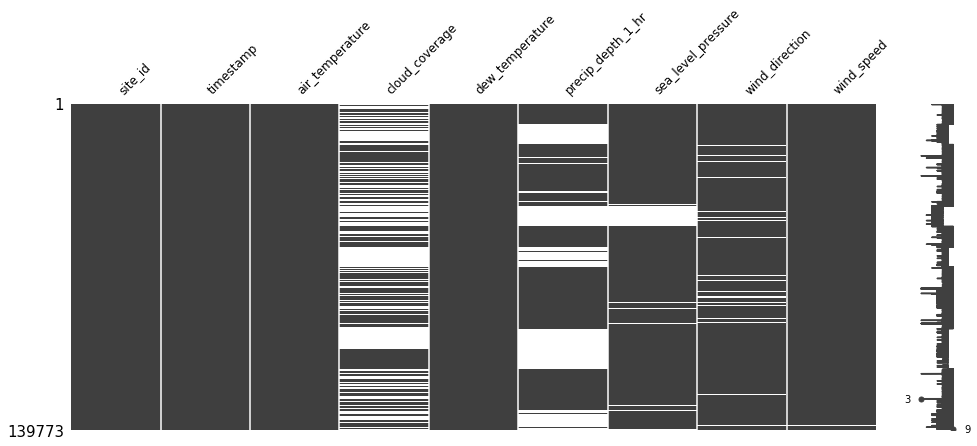

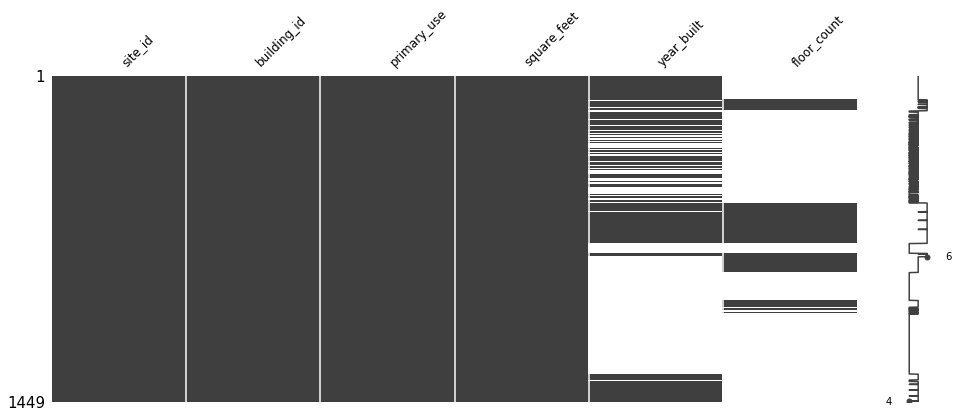

In [7]:
missingno.matrix(weather_train_df, figsize=(16,6), fontsize=12);
missingno.matrix(building_df, figsize=(16,6), fontsize=12);

Feature corerlation with target

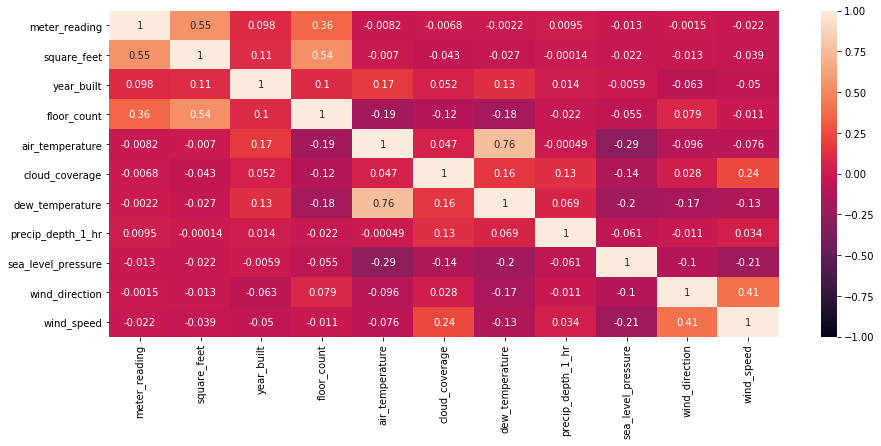

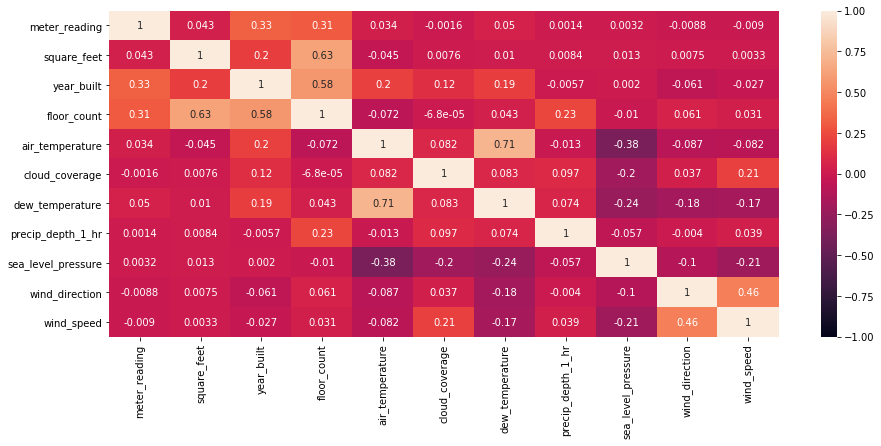

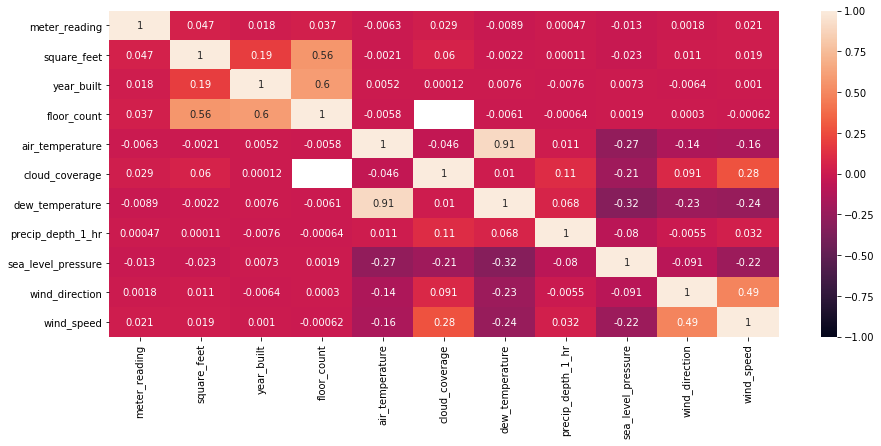

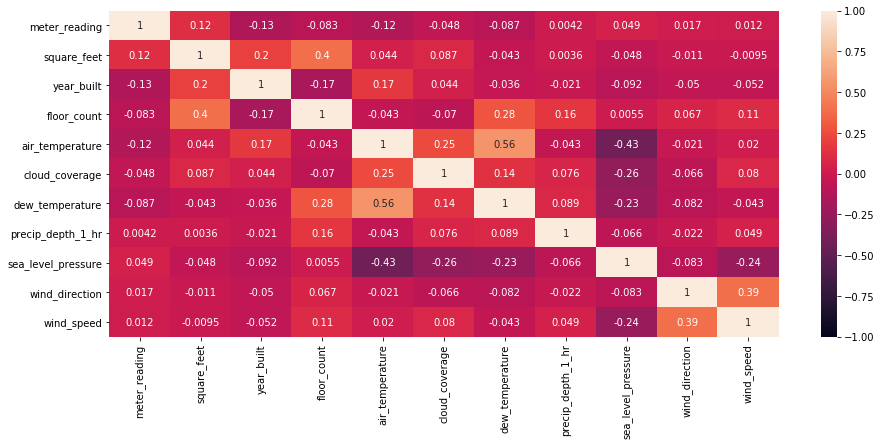

In [10]:
for i in range(0,4):
    corr = merge_train_df[merge_train_df.meter == i][['timestamp','meter_reading','square_feet','year_built','floor_count',
             'air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr',
             'sea_level_pressure','wind_direction','wind_speed']].corr()
    f, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

<Figure size 1152x360 with 0 Axes>

Text(0.5, 1.0, 'Meter Reading')

Text(0, 0.5, 'Count of readings')

Text(0.5, 0, 'Measured consumption')

(0, 22004700.0)

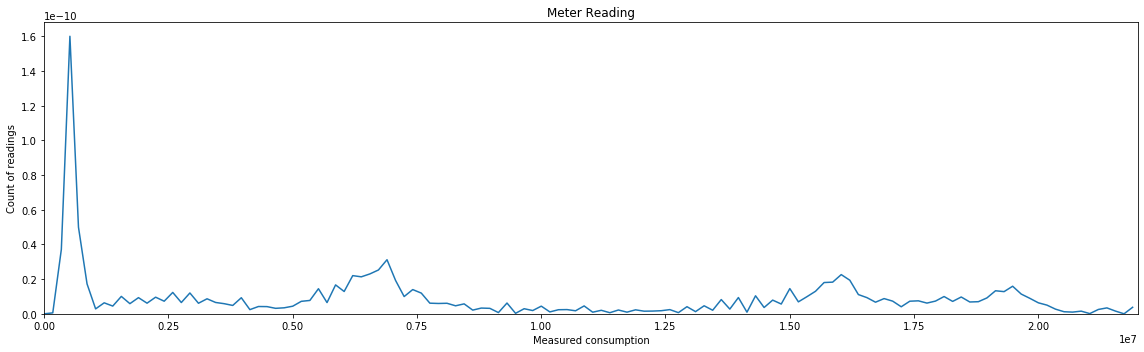

In [20]:
plt.figure(figsize=(16,5))
sns.distplot(train_df.meter_reading, hist=False)
plt.title(f"Meter Reading")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.xlim(0, train_df.meter_reading.max() + 100_000)
plt.tight_layout()
plt.show()

<Figure size 1152x360 with 0 Axes>

Text(0.5, 1.0, 'log transform of Meter Reading')

Text(0, 0.5, 'Count of readings')

Text(0.5, 0, 'Measured consumption')

(0, 12)

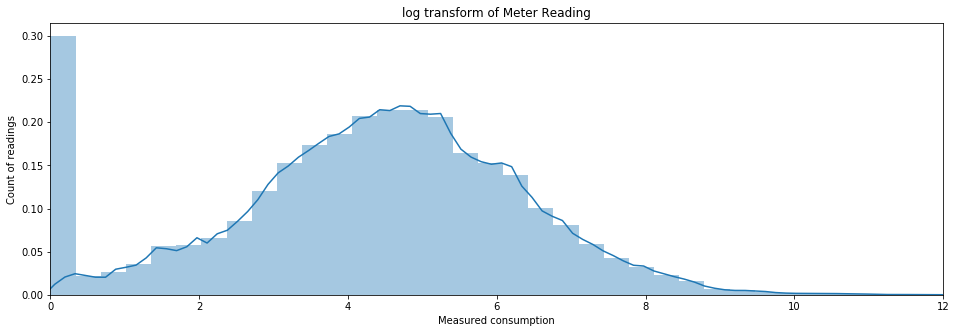

In [21]:
plt.figure(figsize=(16,5))
sns.distplot(np.log1p(train_df.meter_reading))
plt.title(f"log transform of Meter Reading")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.xlim(0, 12)
plt.show()

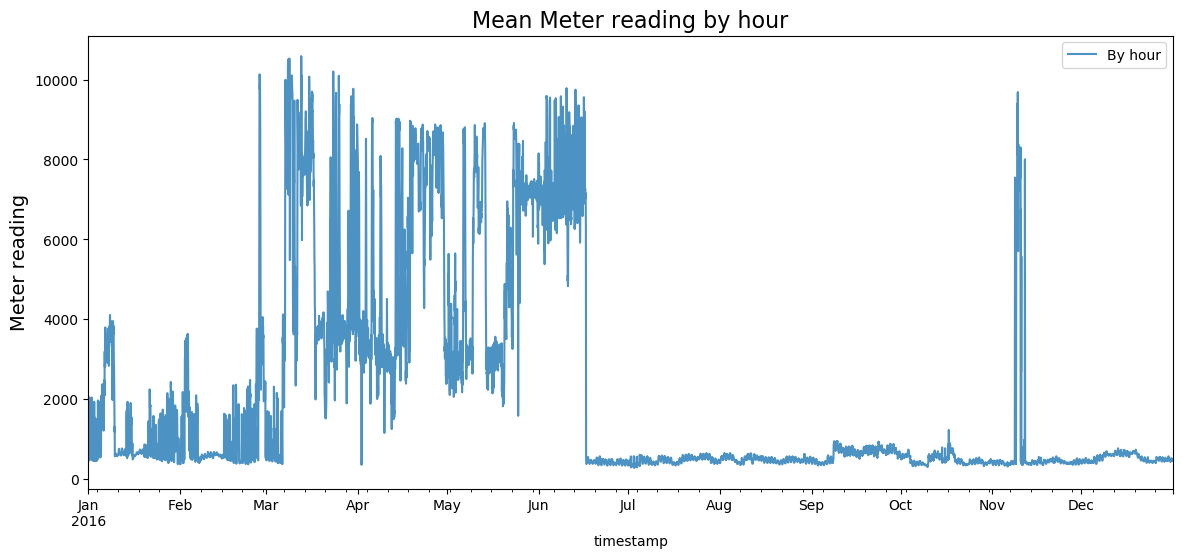

In [23]:
# visualize meter reading in time order
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
train_df[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()\
         ['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).\
         set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour', fontsize=16);
axes.legend();

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 0')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 1')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 2')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 3')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 4')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 5')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 6')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 7')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 8')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 9')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 10')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 11')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 12')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 13')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 14')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'site_id 15')

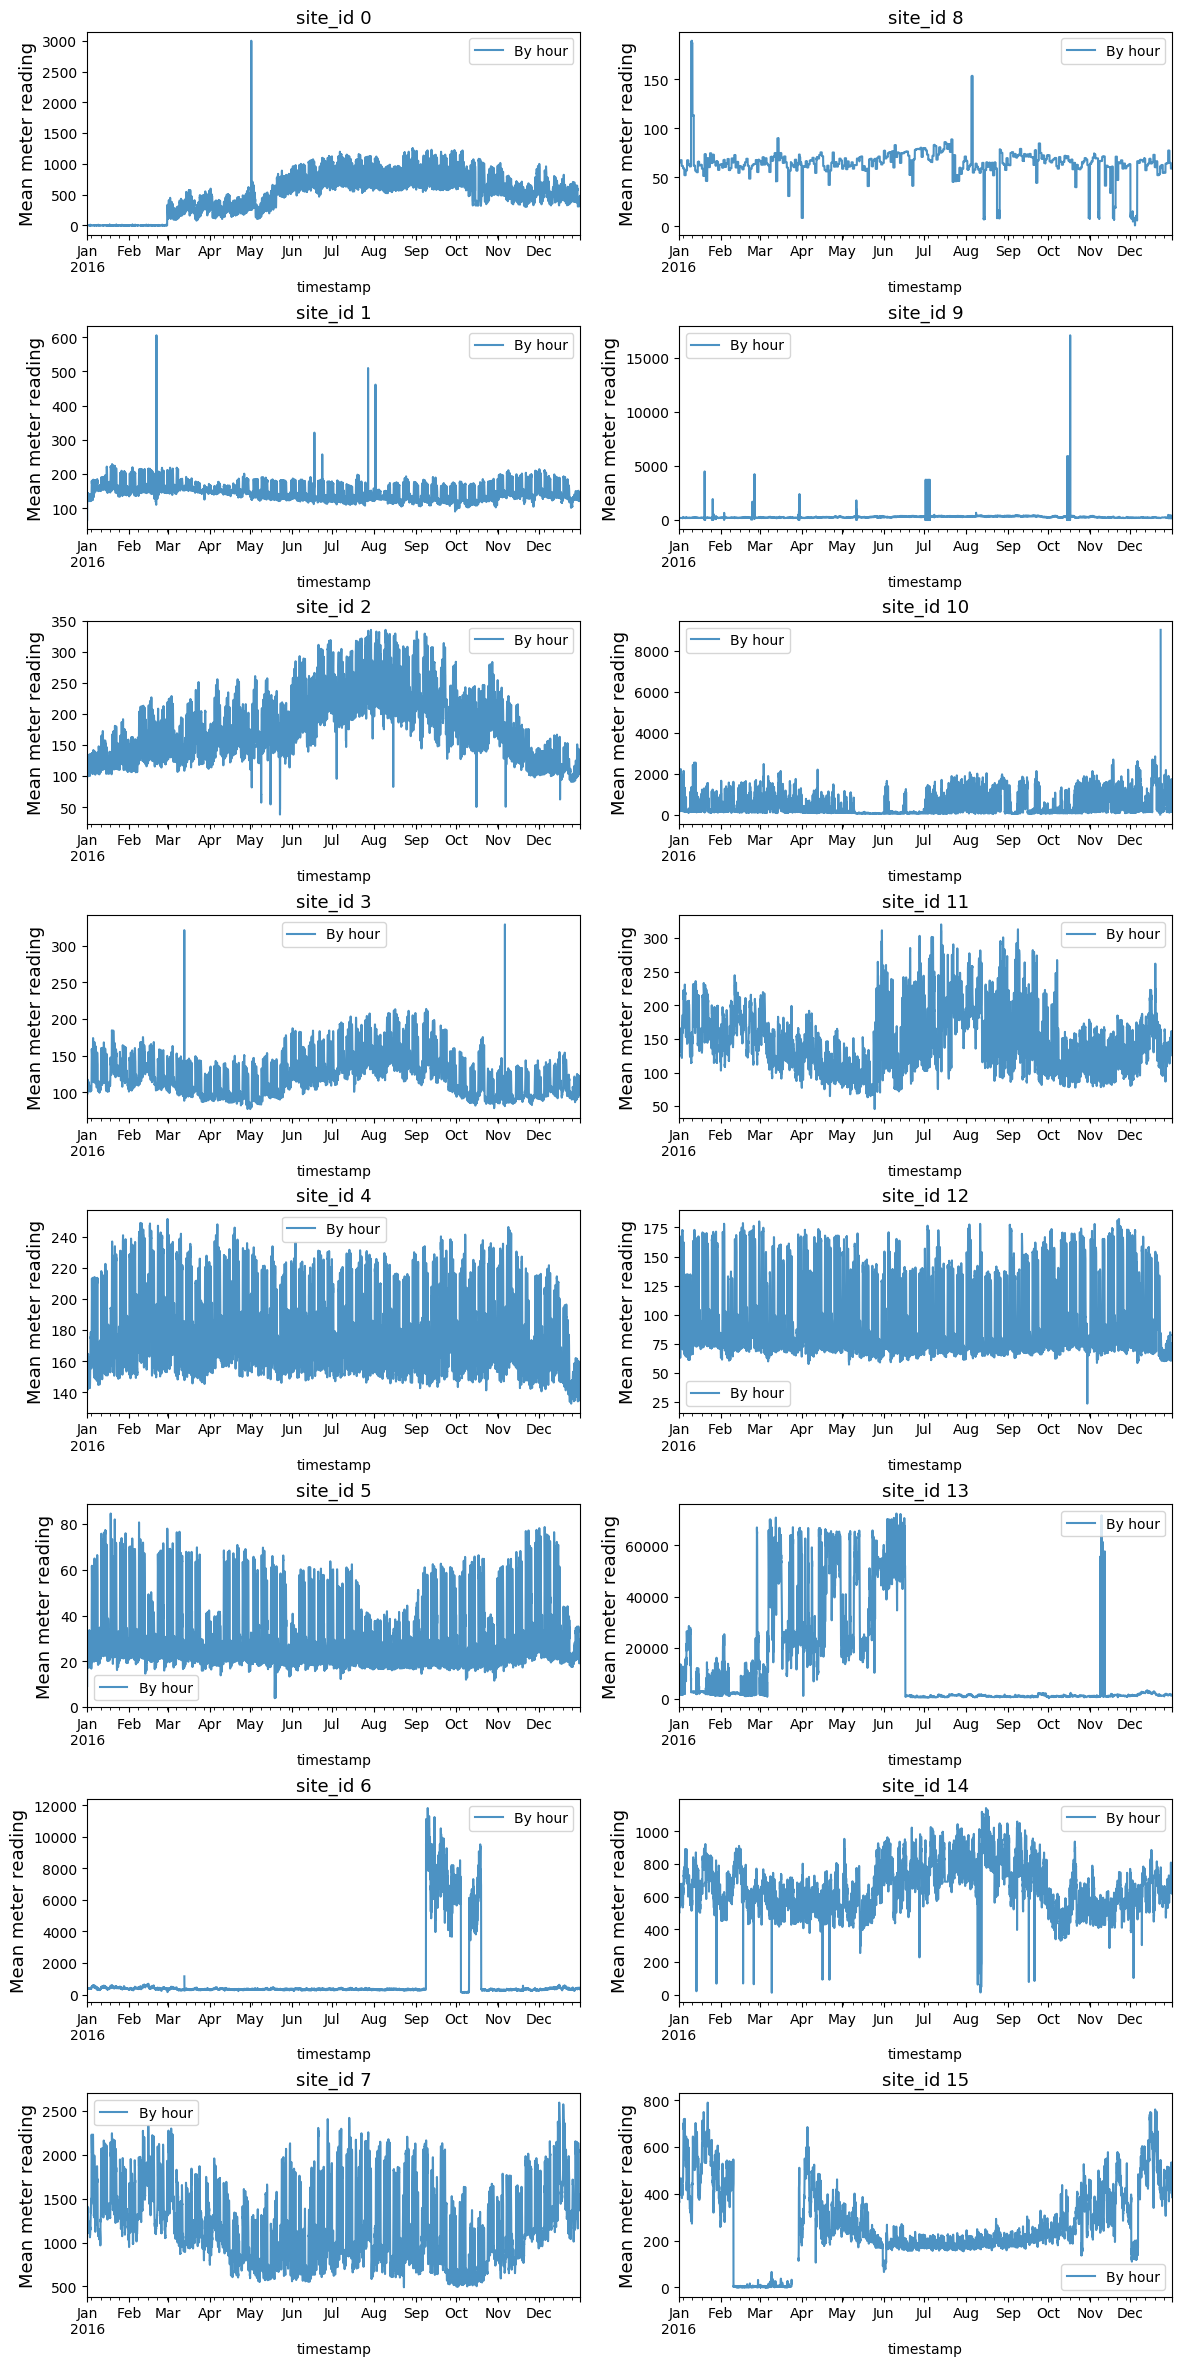

In [24]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(merge_train_df['site_id'].nunique()):
    merge_train_df[merge_train_df['site_id'] == i][['timestamp', 'meter_reading']].\
                        set_index('timestamp').resample('H').mean()['meter_reading'].\
                        plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').\
                        set_ylabel('Mean meter reading', fontsize=13);
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Education')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Office')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Entertainment/public assembly')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Lodging/residential')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Public services')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Healthcare')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Other')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Parking')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Manufacturing/industrial')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Food sales and service')

IndexError: index 0 is out of bounds for axis 0 with size 0

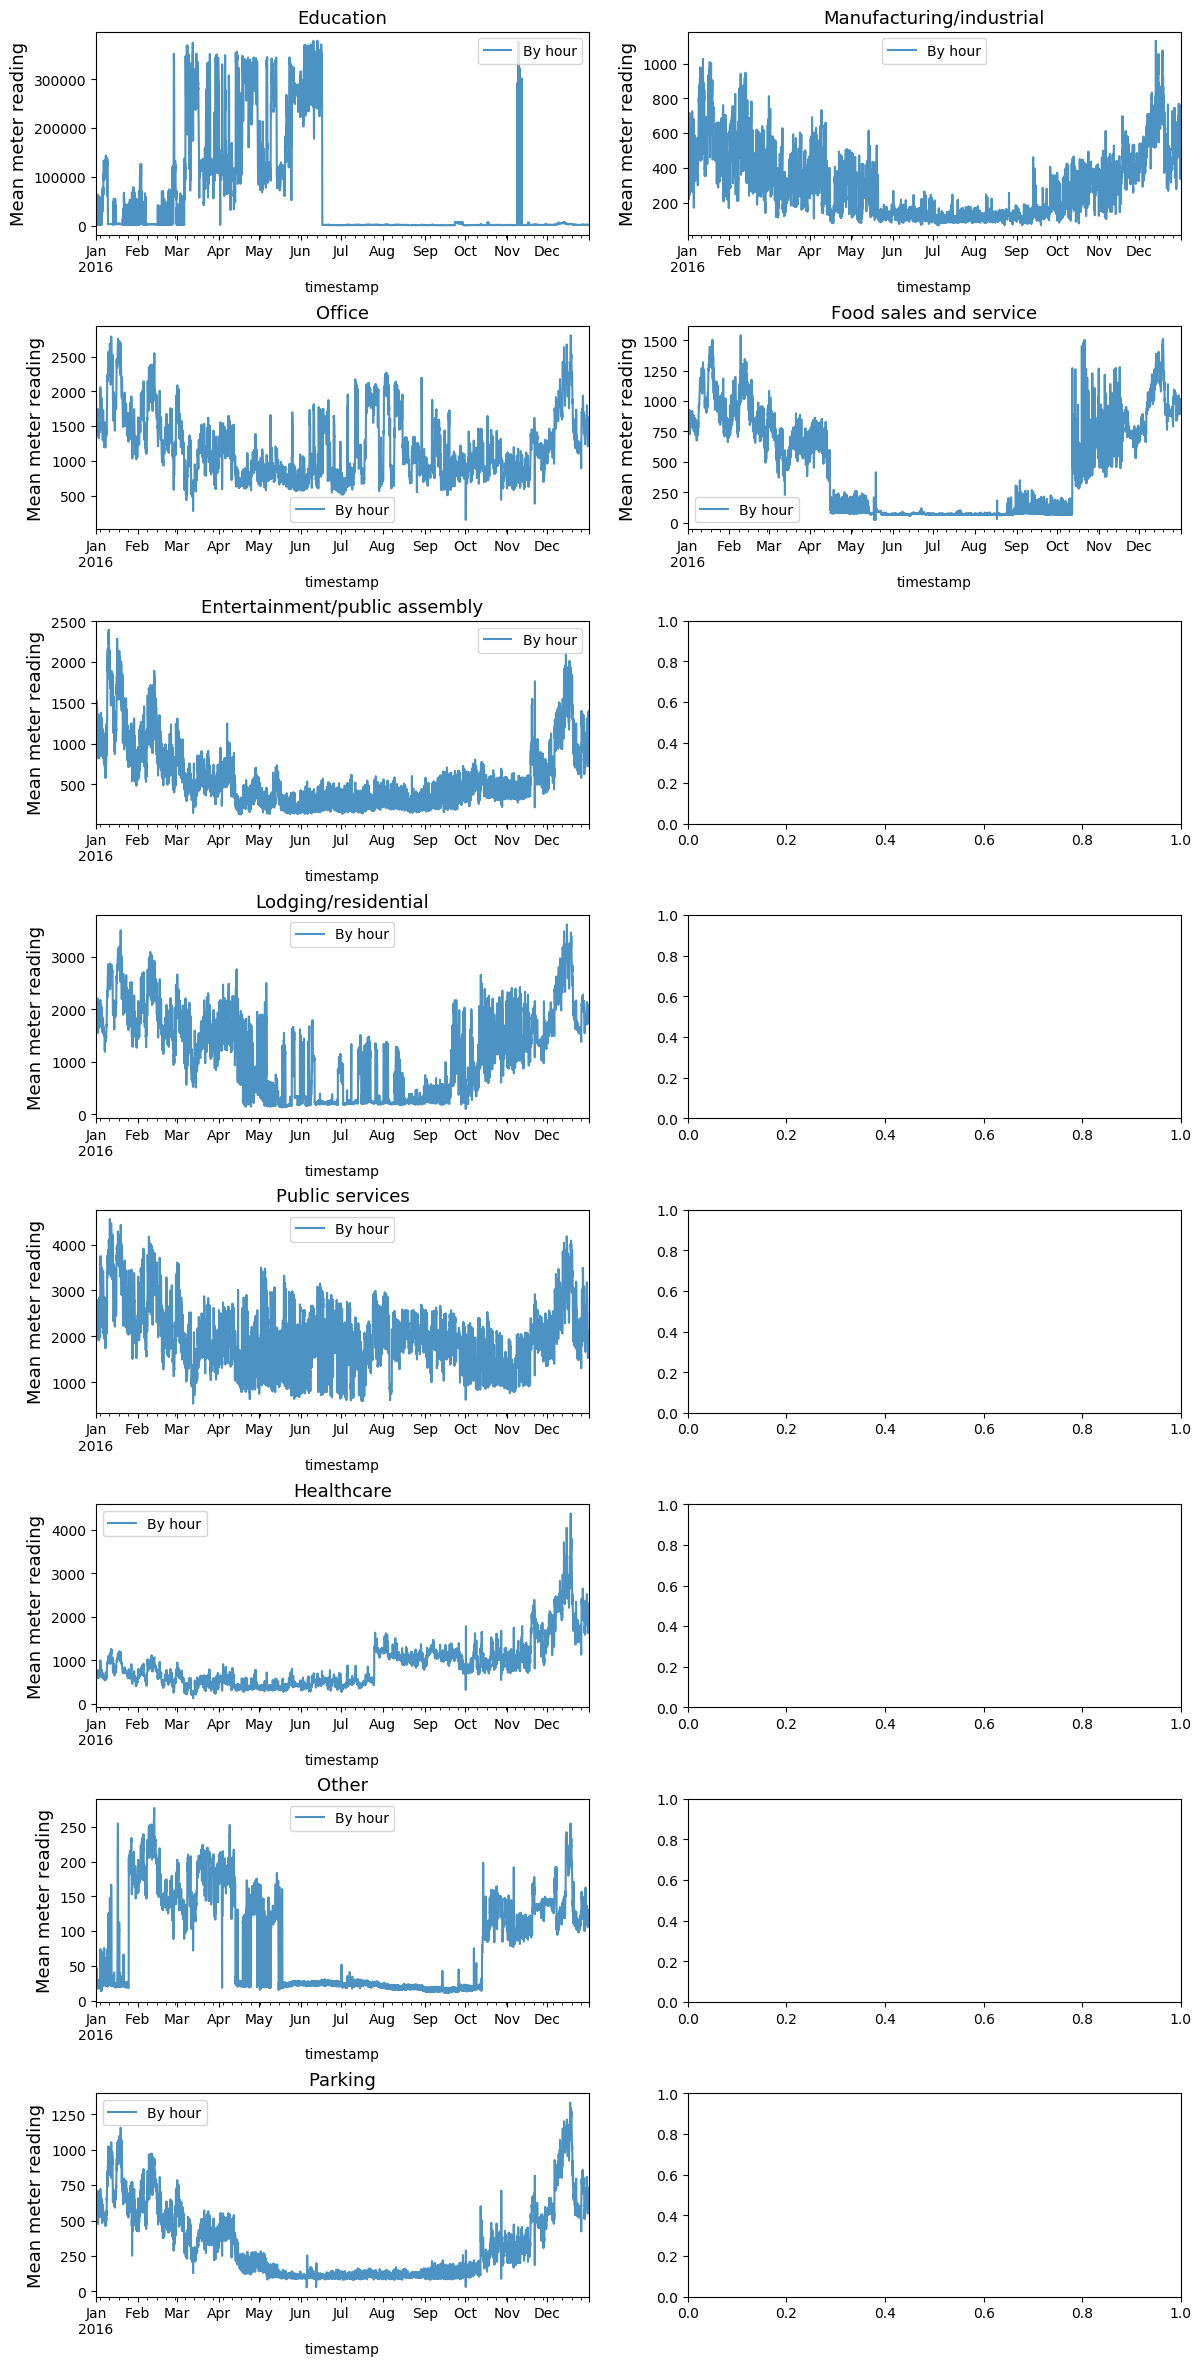

In [35]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i, use in enumerate(merge_train_df['primary_use'].value_counts().index.to_list()):
    try:
        merge_train_df[(merge_train_df['site_id'] == 13) & (merge_train_df['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').\
             resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').\
             set_ylabel('Mean meter reading', fontsize=13);
       
        axes[i%8][i//8].legend();
    except TypeError:
        pass
    axes[i%8][i//8].set_title(use, fontsize=13);
    plt.subplots_adjust(hspace=0.45)

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Education')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Office')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Entertainment/public assembly')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Lodging/residential')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Public services')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Healthcare')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Other')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Parking')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Manufacturing/industrial')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Food sales and service')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Retail')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Warehouse/storage')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Services')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Technology/science')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Utility')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Religious worship')

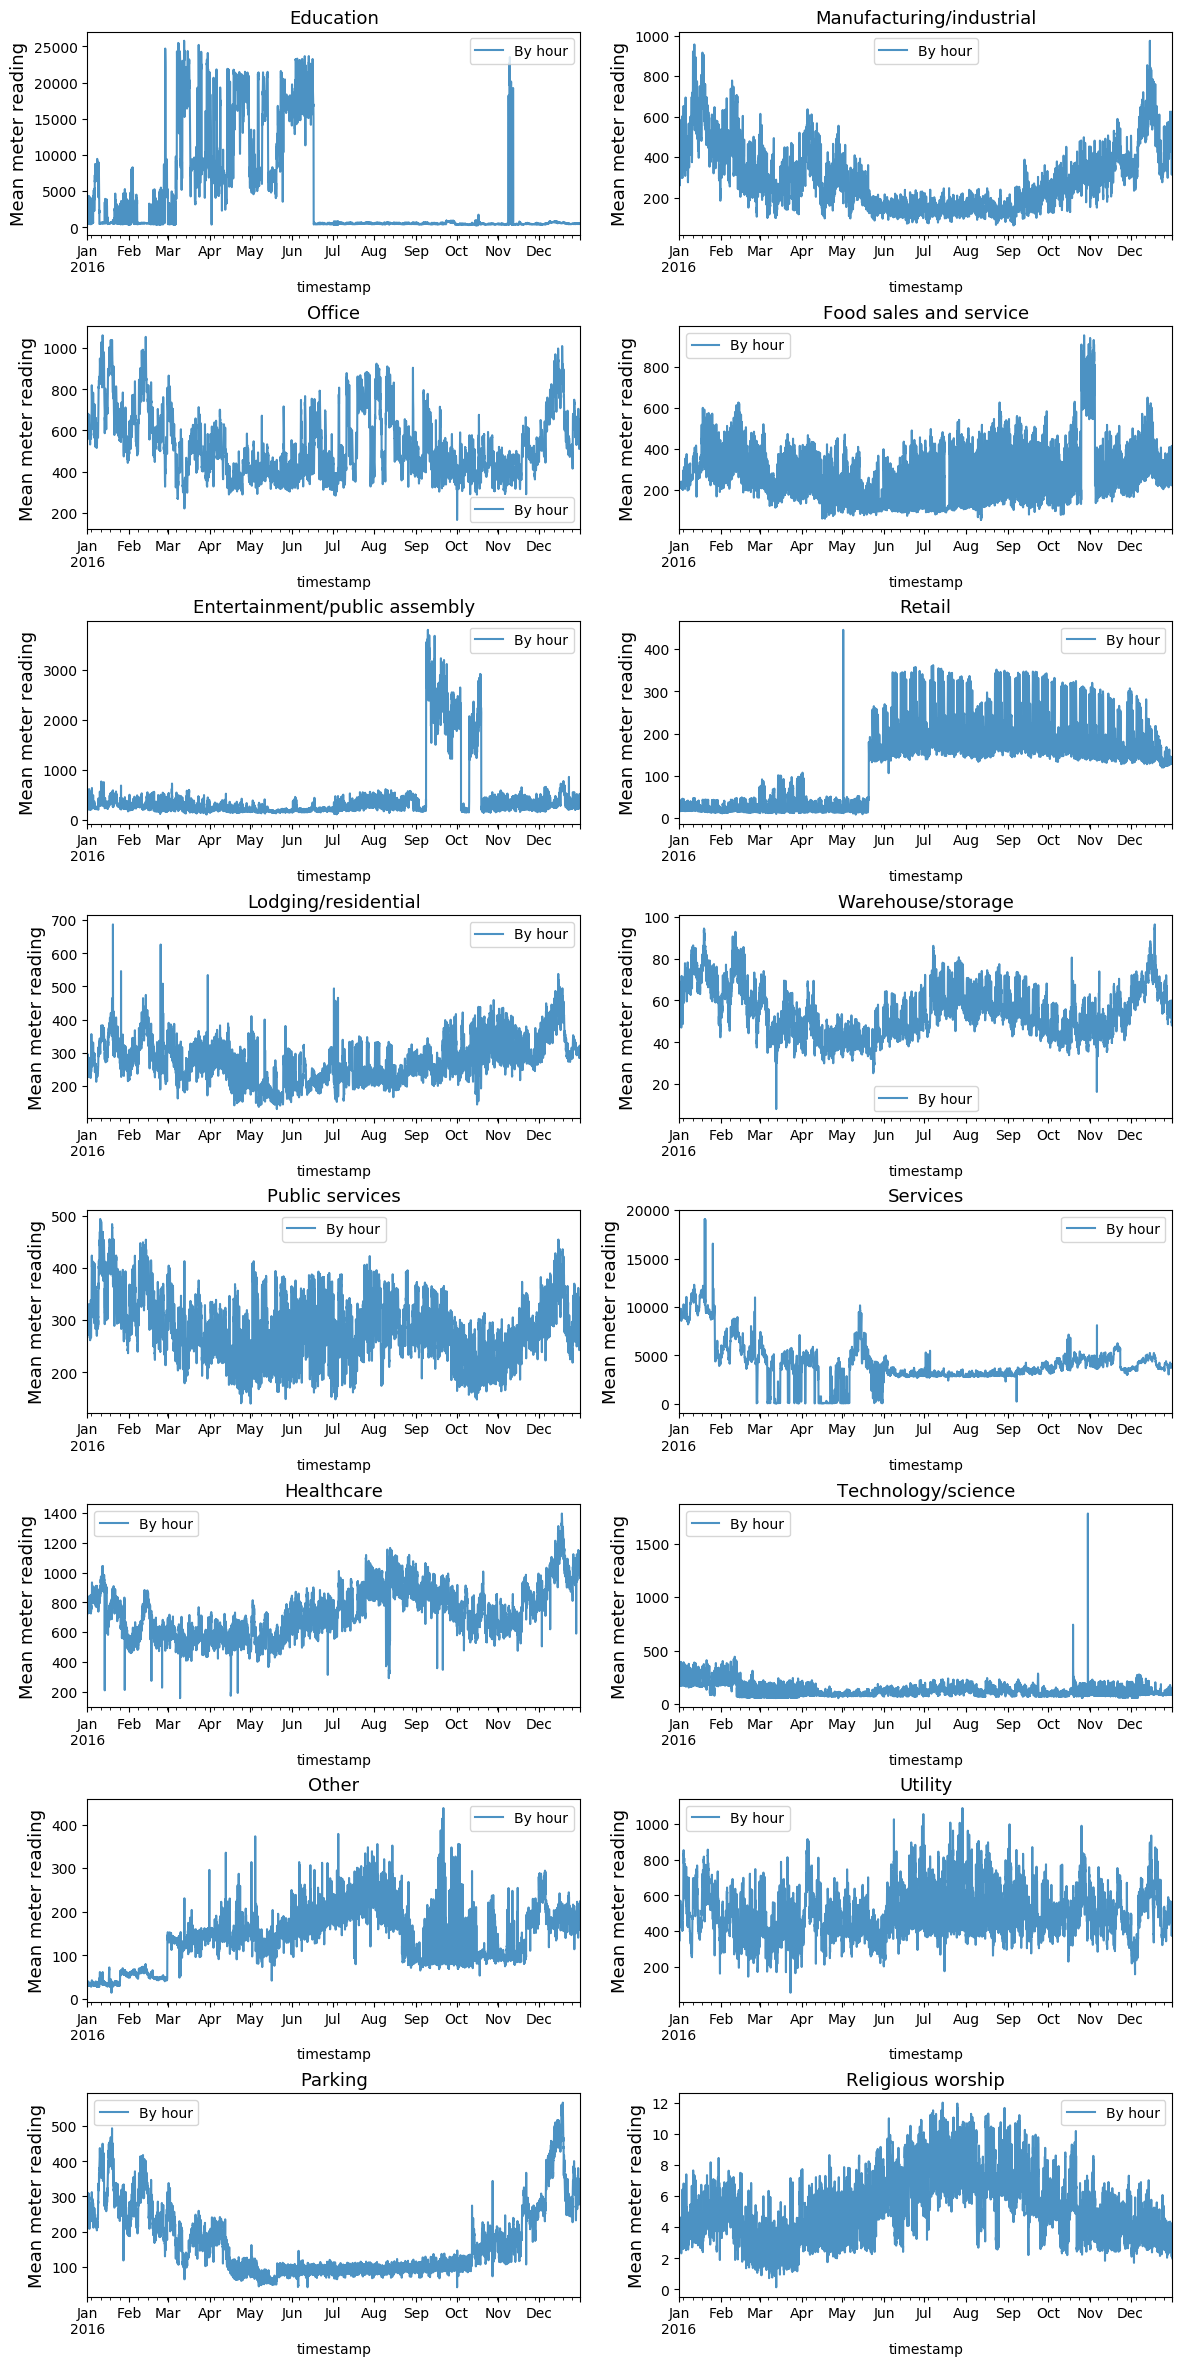

In [36]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i, use in enumerate(merge_train_df['primary_use'].value_counts().index.to_list()):
    try:
        merge_train_df[ (merge_train_df['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').\
             resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').\
             set_ylabel('Mean meter reading', fontsize=13);
       
        axes[i%8][i//8].legend();
    except TypeError:
        pass
    axes[i%8][i//8].set_title(use, fontsize=13);
    plt.subplots_adjust(hspace=0.45)

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Meter: 0')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Meter: 1')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Meter: 2')

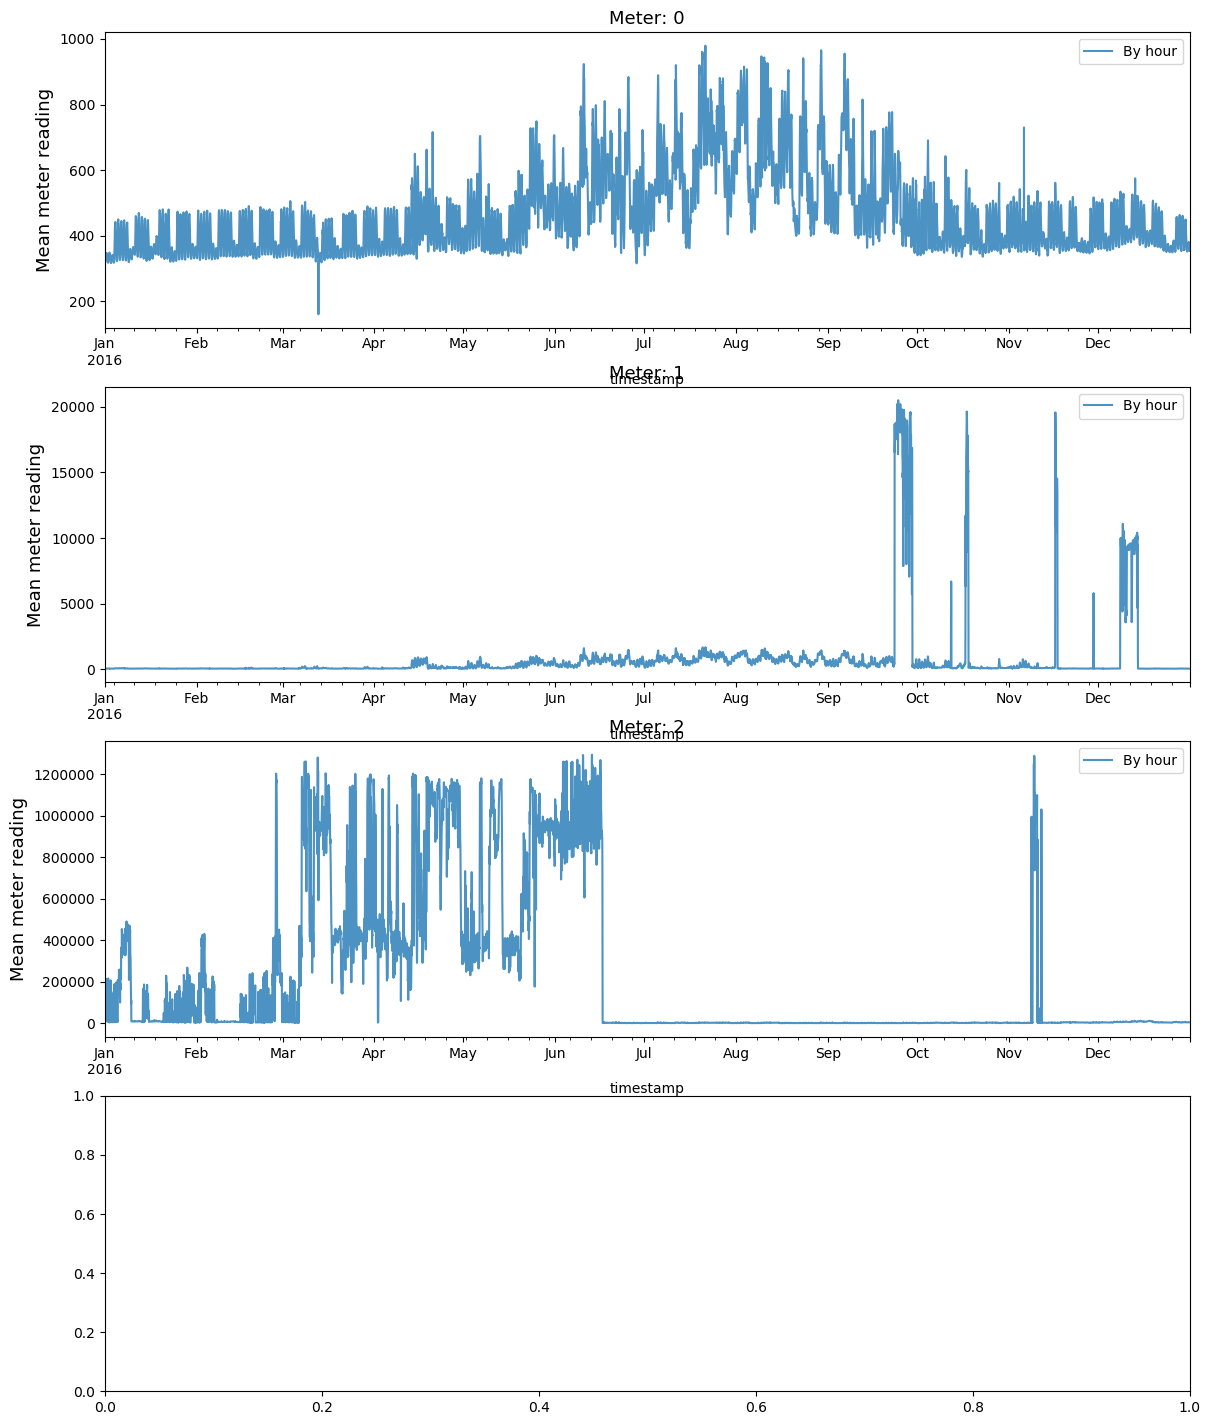

In [45]:
fig, axes = plt.subplots(4,1,figsize=(14, 18), dpi=100)
for i in merge_train_df[(merge_train_df['site_id'] == 13) & (merge_train_df['primary_use'] == 'Education')]['meter'].value_counts(dropna=False).index.to_list():
    merge_train_df[(merge_train_df['site_id'] == 13) & (merge_train_df['primary_use'] == 'Education') & (merge_train_df['meter'] == i)]\
         [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].\
         plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel \
         ('Mean meter reading', fontsize=13);

    axes[i].legend();
    axes[i].set_title('Meter: ' + str(i), fontsize=13);

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Meter: 0')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Meter: 1')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Meter: 2')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'Meter: 3')

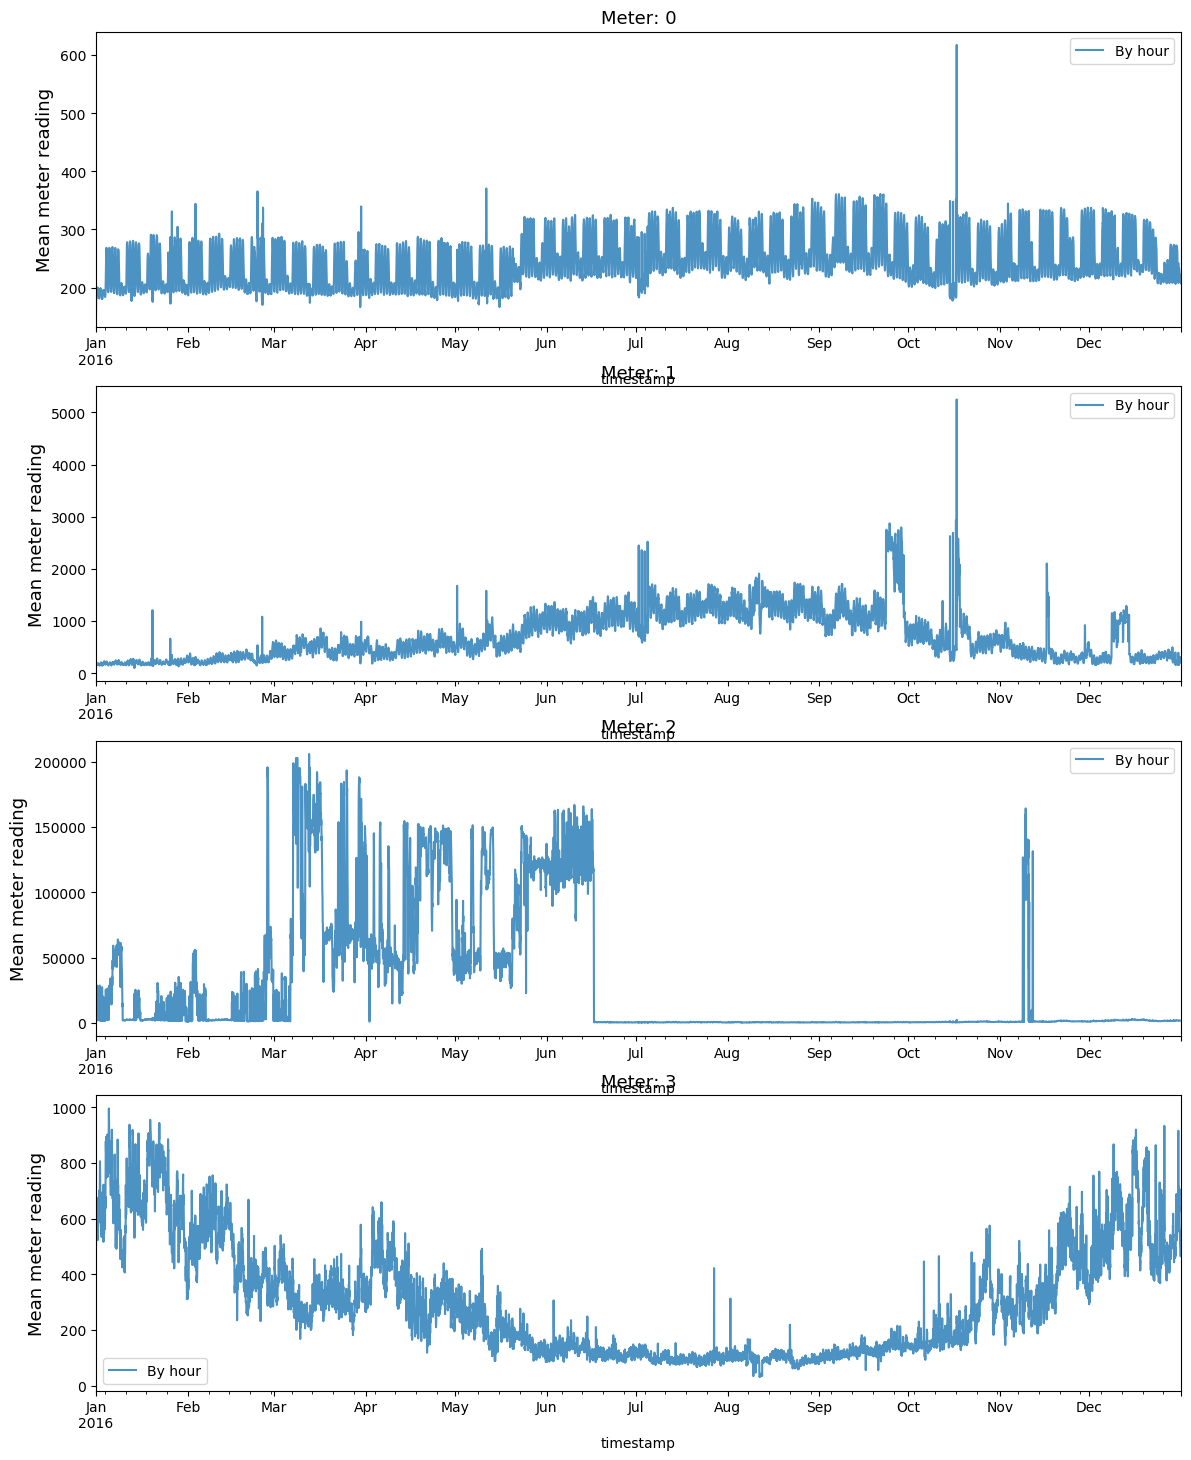

In [49]:
fig, axes = plt.subplots(4,1,figsize=(14, 18), dpi=100)
for i in merge_train_df[ (merge_train_df['primary_use'] == 'Education')]['meter'].value_counts(dropna=False).index.to_list():
    merge_train_df[ (merge_train_df['primary_use'] == 'Education') & (merge_train_df['meter'] == i)]\
         [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].\
         plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel \
         ('Mean meter reading', fontsize=13);

    axes[i].legend();
    axes[i].set_title('Meter: ' + str(i), fontsize=13);

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1140')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1126')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1176')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1178')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1180')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1191')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1198')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1079')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1080')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1085')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1088')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1099')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1107')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1121')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1156')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1157')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id: 1169')

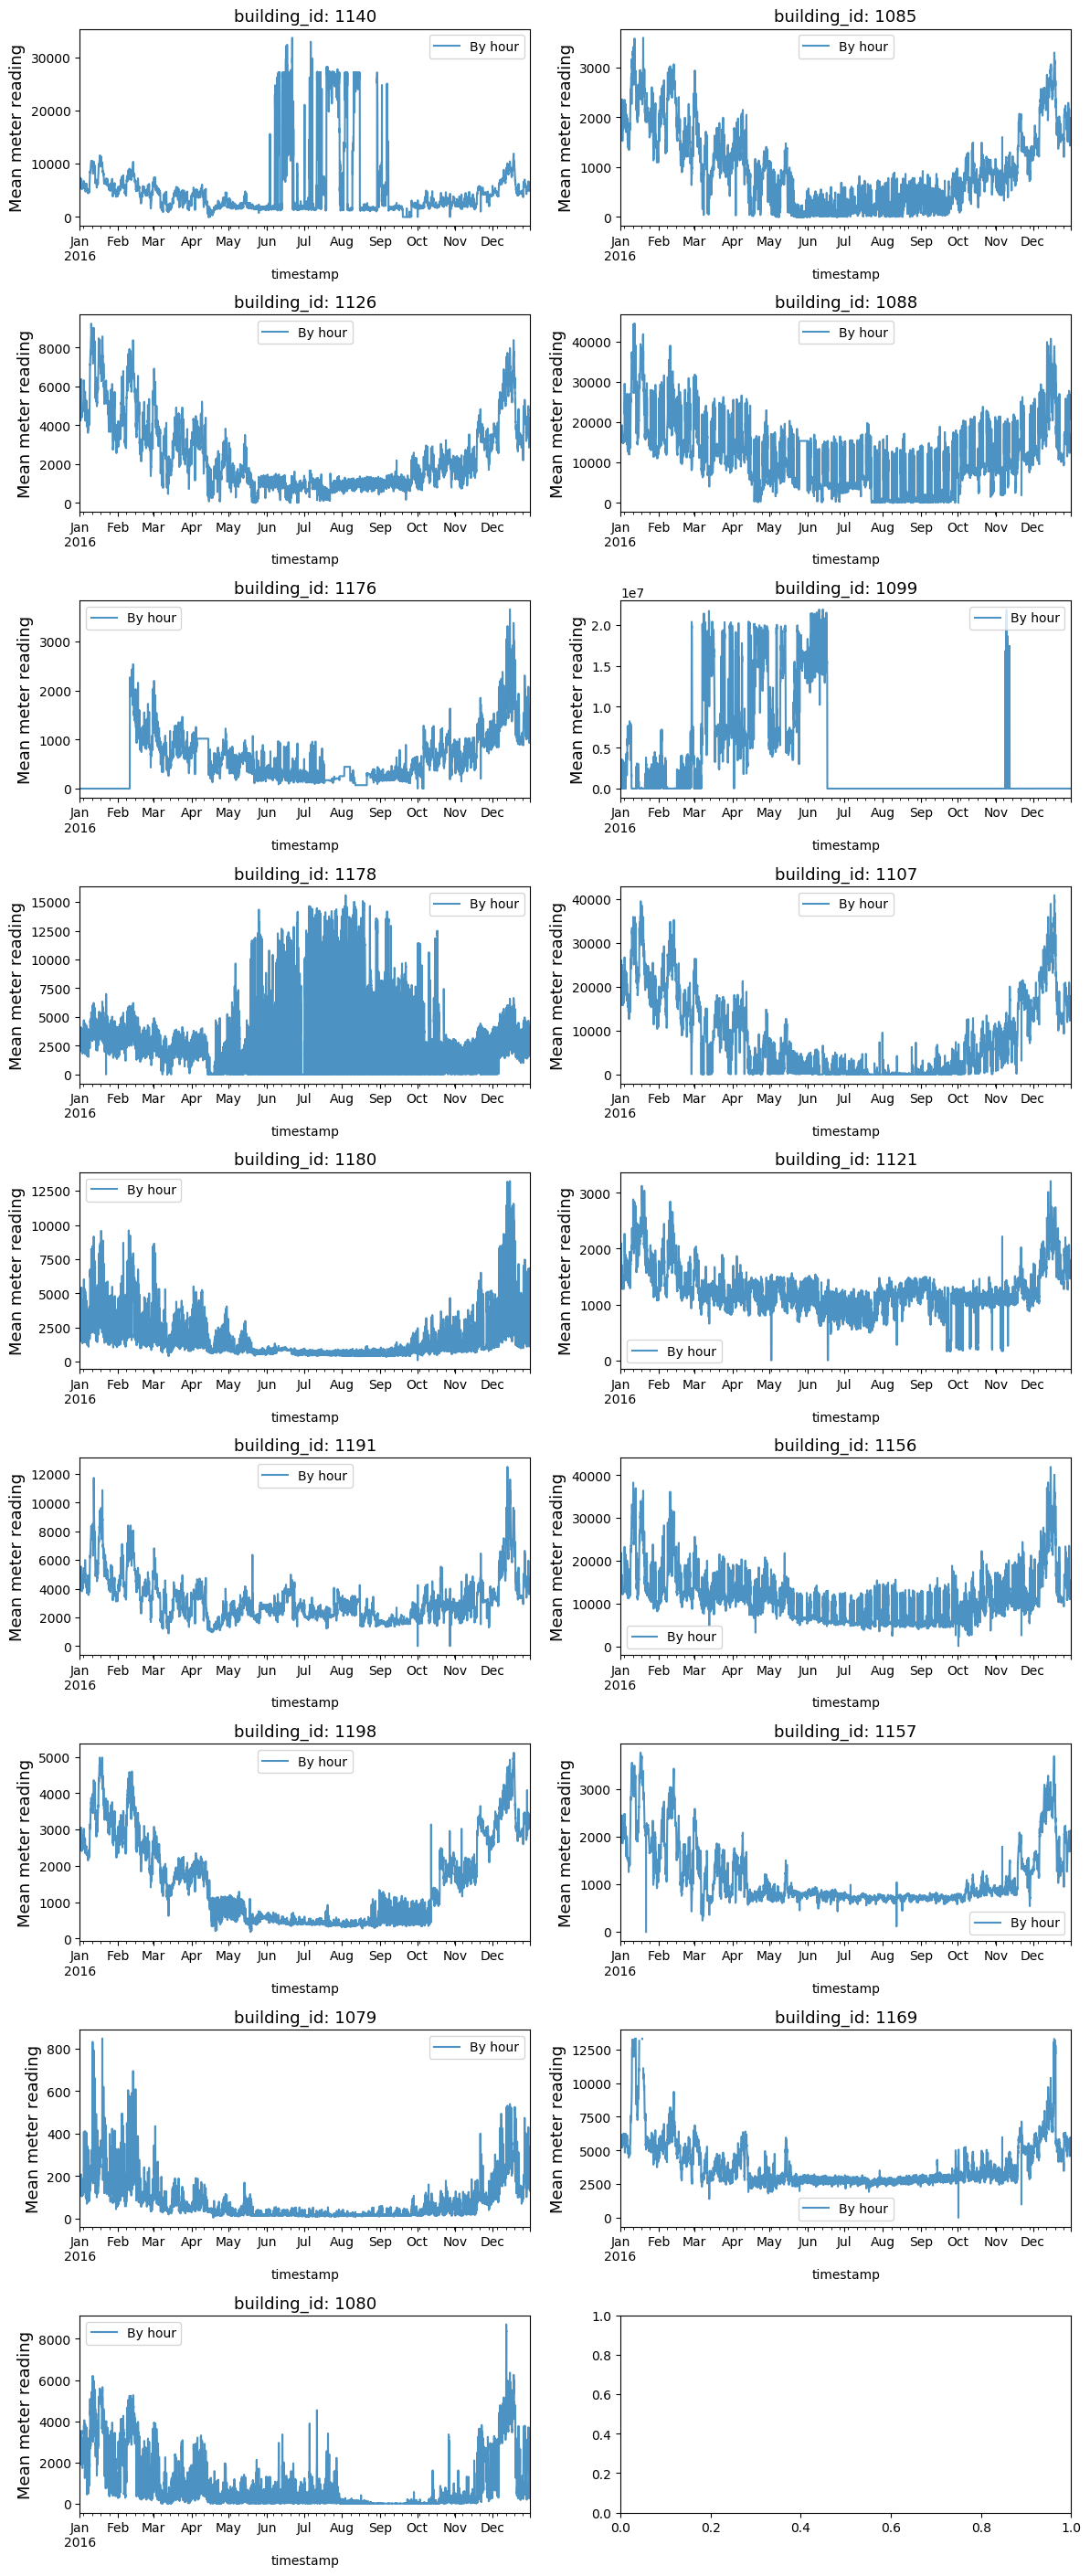

In [52]:
fig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
for i, building in enumerate(merge_train_df[(merge_train_df['site_id'] == 13) & (merge_train_df['primary_use'] == 'Education') & (merge_train_df['meter'] == 2)]['building_id'].value_counts(dropna=False).index.to_list()):
    merge_train_df[(merge_train_df['site_id'] == 13) & (merge_train_df['primary_use'] == 'Education') & \
                   (merge_train_df['meter'] == 2) & (merge_train_df['building_id'] == building)]\
                    [['timestamp', 'meter_reading']].set_index('timestamp').resample('H').\
                    mean()['meter_reading'].plot(ax=axes[i%9][i//9], alpha=0.8, label='By hour', color='tab:blue').\
                    set_ylabel('Mean meter reading', fontsize=13);

    axes[i%9][i//9].legend();
    axes[i%9][i//9].set_title('building_id: ' + str(building), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

Text(0, 0.5, 'Mean meter reading')

Text(0, 0.5, 'Mean meter reading')

Text(0, 0.5, 'Mean meter reading')

Text(0.5, 1.0, 'building_id==1099 and meter==2')

Text(0.5, 1.0, 'Full dataset')

Text(0.5, 1.0, 'building_id 1099 excluded')

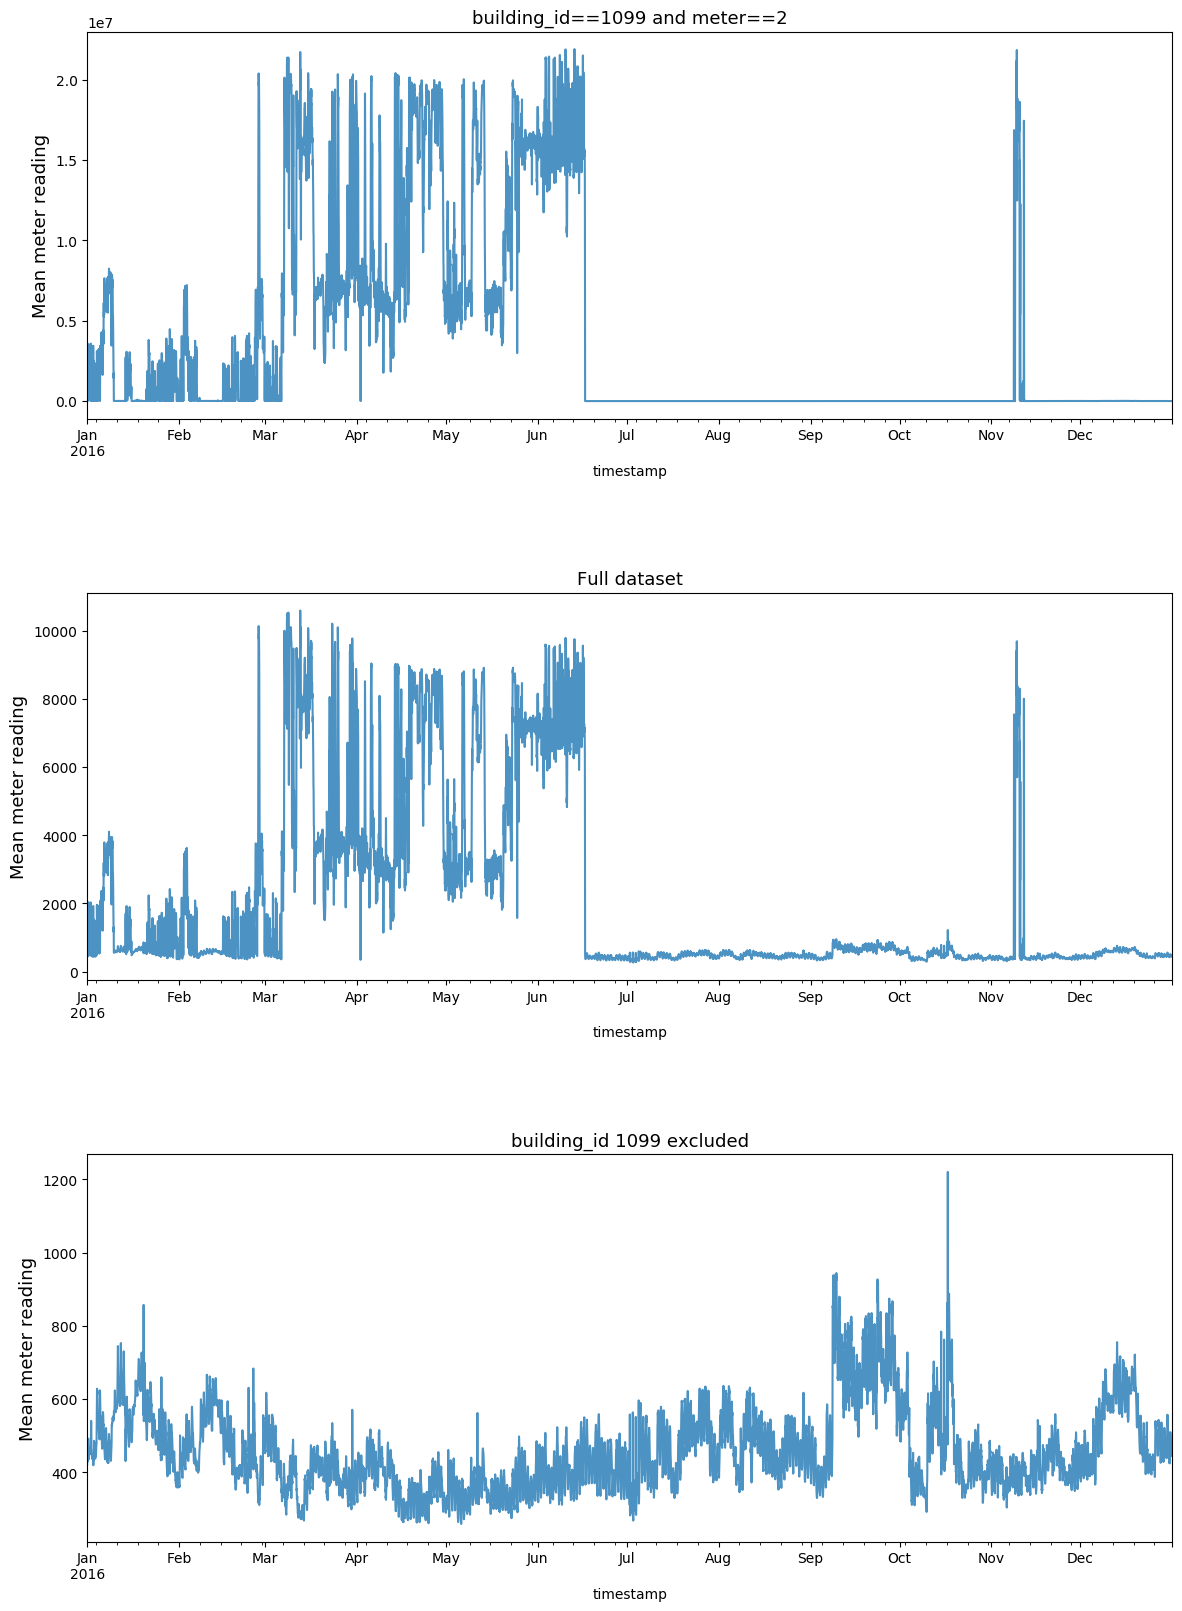

In [29]:
fig, axes = plt.subplots(3,1,figsize=(14, 20), dpi=100)
# build = 1099 and meter = 2
merge_train_df[(merge_train_df['meter'] == 2) & (merge_train_df['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[0], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
# not build 1099 and meter = 2
merge_train_df[~((merge_train_df['meter'] == 2) & (merge_train_df['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[2], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
#overall data
merge_train_df[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[1], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);

axes[0].set_title('building_id==1099 and meter==2', fontsize=13);
axes[1].set_title('Full dataset', fontsize=13);
axes[2].set_title('building_id 1099 excluded', fontsize=13);
plt.subplots_adjust(hspace=0.45)

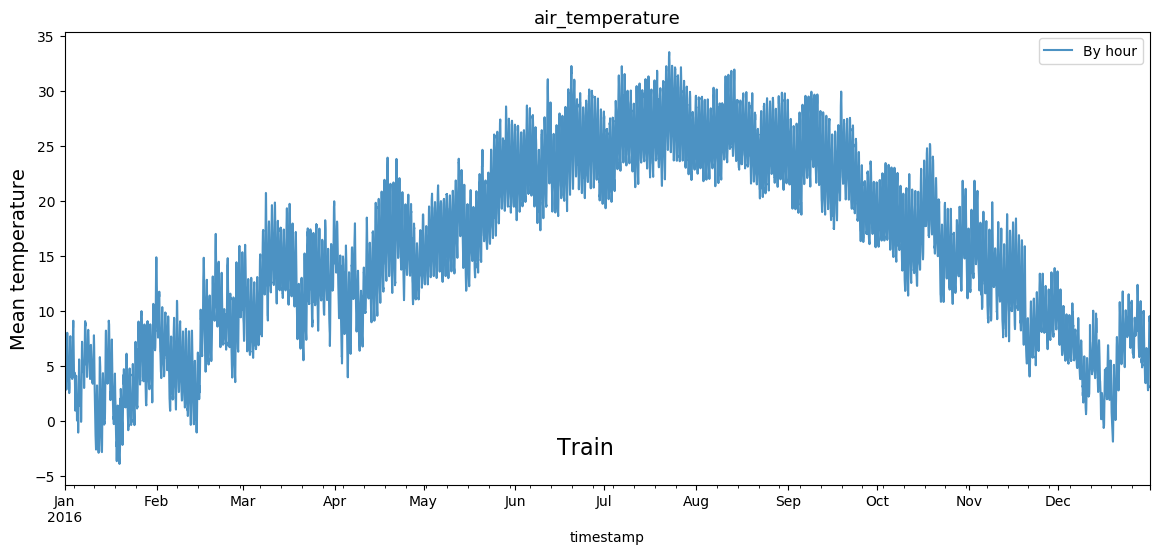

In [30]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
merge_train_df[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean temperature', fontsize=14);
axes.set_title("air_temperature",fontsize = 13)
axes.text(merge_train_df['timestamp'].iloc[9000000], -3, 'Train', fontsize=16);
axes.legend();


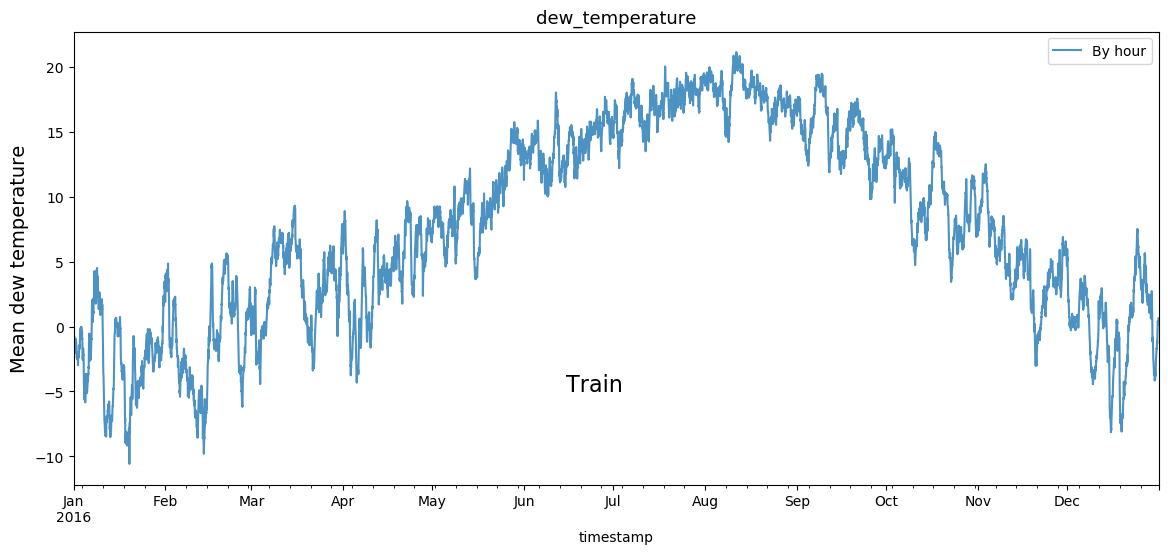

In [31]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
merge_train_df[['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean dew temperature', fontsize=14);
axes.set_title("dew_temperature",fontsize = 13)
axes.legend();
axes.text(merge_train_df['timestamp'].iloc[9000000], -5, 'Train', fontsize=16);

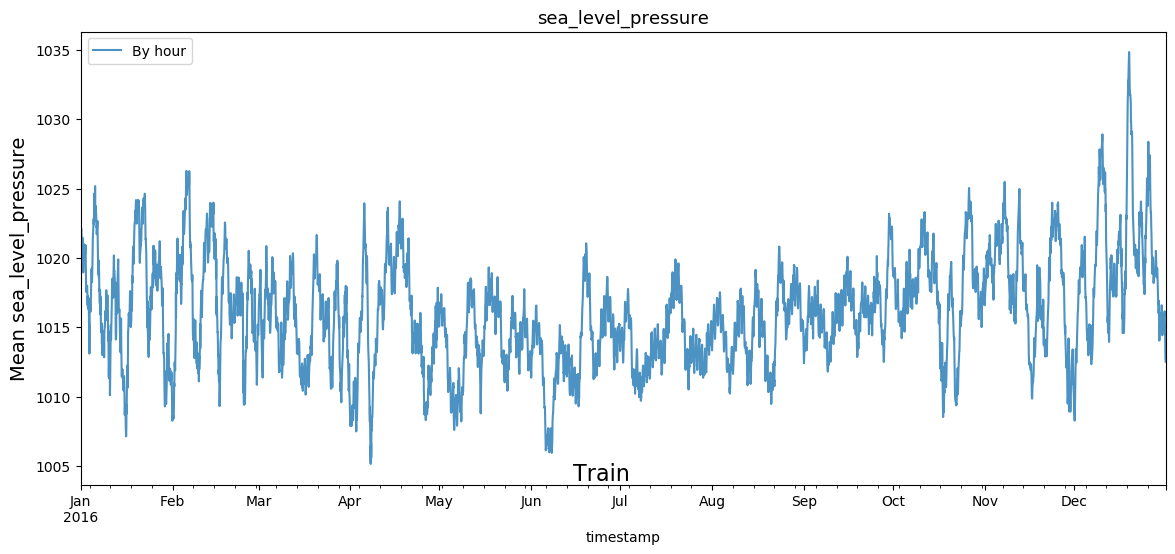

In [32]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
merge_train_df[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean sea_level_pressure', fontsize=14);
axes.legend();
axes.set_title("sea_level_pressure",fontsize = 13)
axes.text(merge_train_df['timestamp'].iloc[9000000], 1004, 'Train', fontsize=16);

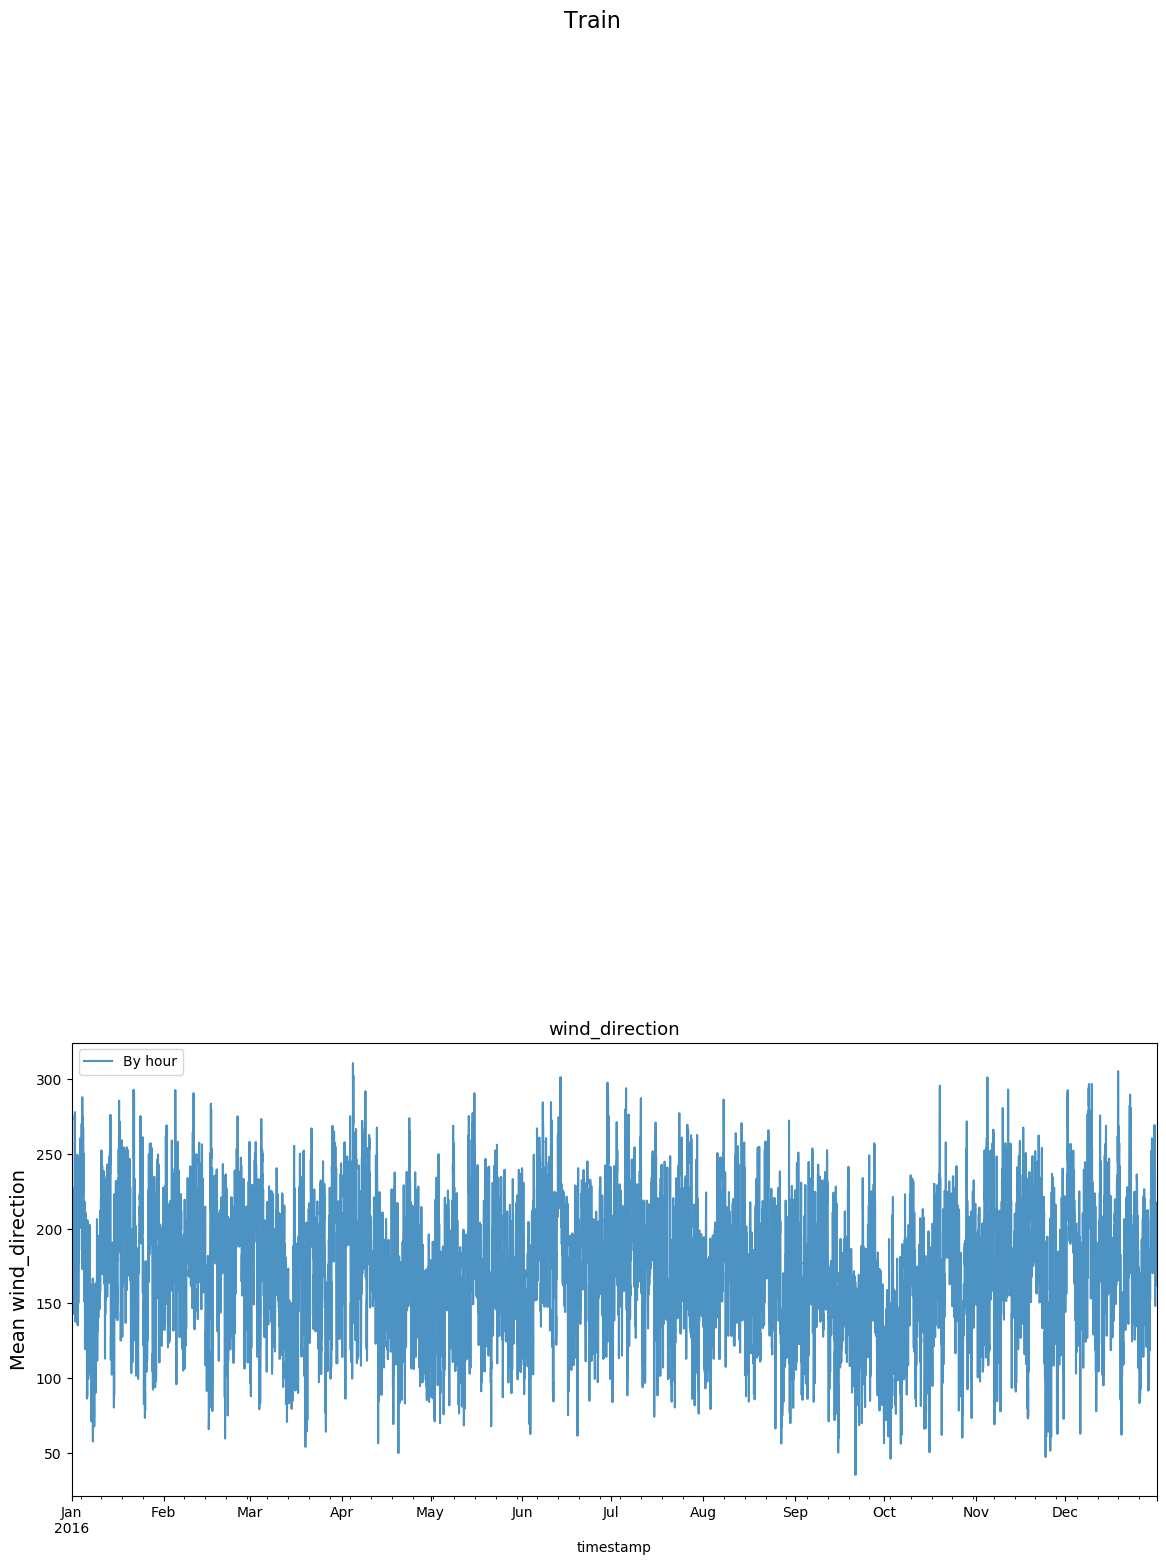

In [42]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
merge_train_df[['timestamp', 'wind_direction']].set_index('timestamp').resample('H').mean()['wind_direction'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean wind_direction', fontsize=14);
axes.legend();
axes.set_title("wind_direction",fontsize = 13)
axes.text(merge_train_df['timestamp'].iloc[9000000], 1004, 'Train', fontsize=16);

In [43]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
merge_train_df[['timestamp', 'cloud_coverage']].set_index('timestamp').resample('H').mean()['cloud_coverage'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean cloud_coverage', fontsize=14);
axes.legend();
axes.set_title("cloud_coverage",fontsize = 13)
axes.text(merge_train_df['timestamp'].iloc[9000000], 1004, 'Train', fontsize=16);

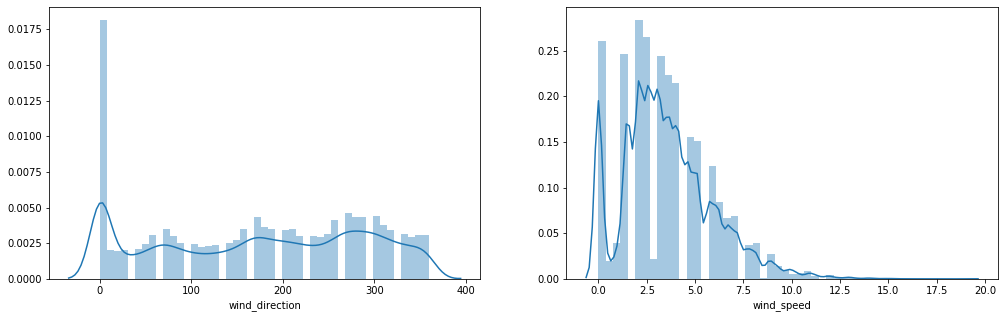

In [34]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
features = ['cloud_coverage', 'precip_depth_1_hr', 'wind_direction', 'wind_speed']
weather_train_df[features] = weather_train_df[features].fillna(0)
sns.distplot(weather_train_df['wind_direction'], ax=ax[0])
sns.distplot(weather_train_df['wind_speed'], ax=ax[1])
plt.show()